In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
date_order = session.query(Measurement.date).order_by(Measurement.date.desc())
date_final = date_order.first()
print(date_final)

past_yr = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print(past_yr)


('2017-08-23',)
2016-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past_yr).all()
data[:10]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(data, columns = ["Date", "Precipitation"])
precip_df.set_index("Date")


,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [15]:
# Sort the dataframe by date
precip_df = precip_df.sort_values(["Date"])
precip_df.head(10)

,Date,Precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
1881,2016-08-23,0.70
1192,2016-08-23,0.02
1,2016-08-24,0.08
1530,2016-08-24,2.15
705,2016-08-24,2.28


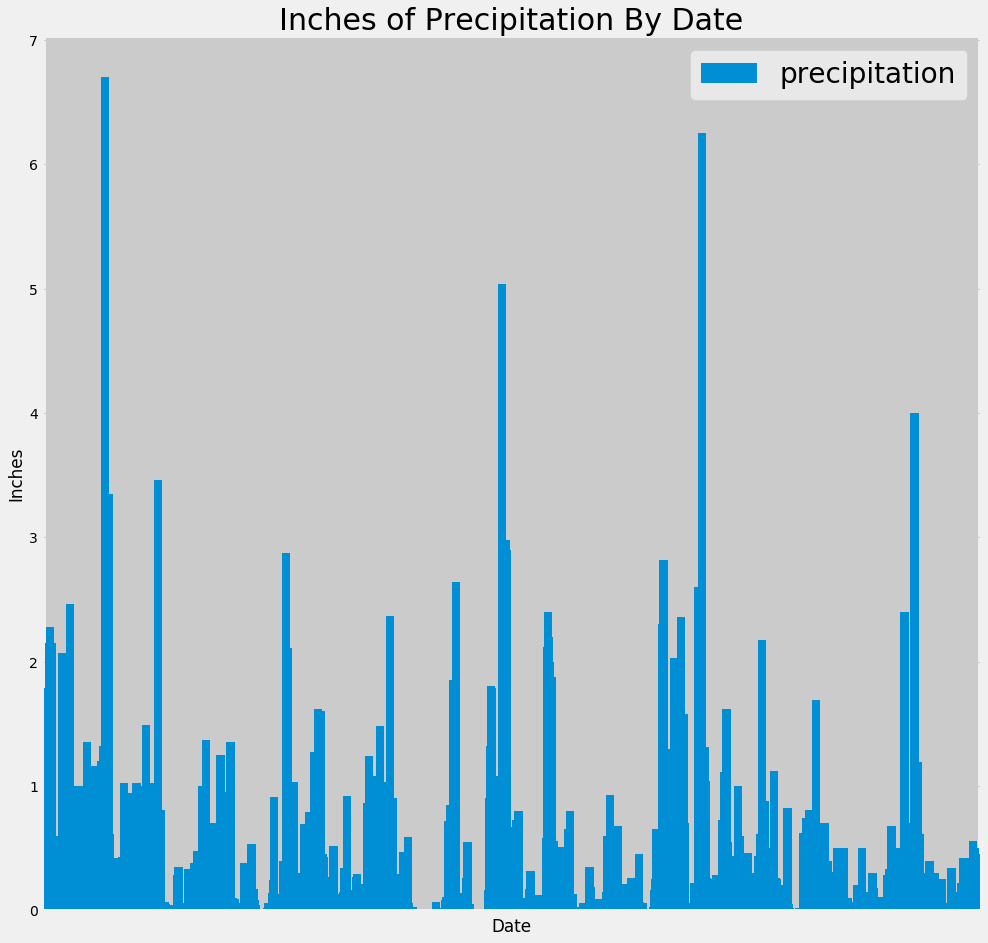

In [35]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot.bar(figsize=(15,15), width = 20)
ax.set_title("Inches of Precipitation By Date", fontsize = 30)
ax.set_ylabel("Inches")
ax.set_xlabel("Date")
ax.set_xticklabels([])
plt.legend(['precipitation'], fontsize=28)
ax.get_legend().set_bbox_to_anchor((1, 1))
plt.grid(b=True, linestyle='-')
plt.savefig("../sqlalchemy-challenge/Images/PrecipitationBar.png")

In [36]:
plt.show()

In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats_df = pd.DataFrame(precip_df["Precipitation"].describe())
summary_stats_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [43]:
# Design a query to show how many stations are available in this dataset?
avail_stations = session.query(Station).group_by(Station.station).count()
print(f"There are {avail_stations} stations available.")

There are 9 stations available.


In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
groupings = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station)
groupings.order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#Which station has the highest number of observations?
highest_observations=session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).first()
most_active_station= highest_observations[0]
most_active_station

'USC00519281'

In [52]:
temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [83]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs=session.query(Measurement.tobs).filter(Measurement.station==most_active_station).filter(Measurement.date>=past_yr).all()
temp_df = pd.DataFrame(temp_obs, columns=["TOBS"])
temp_df.head()

,TOBS
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


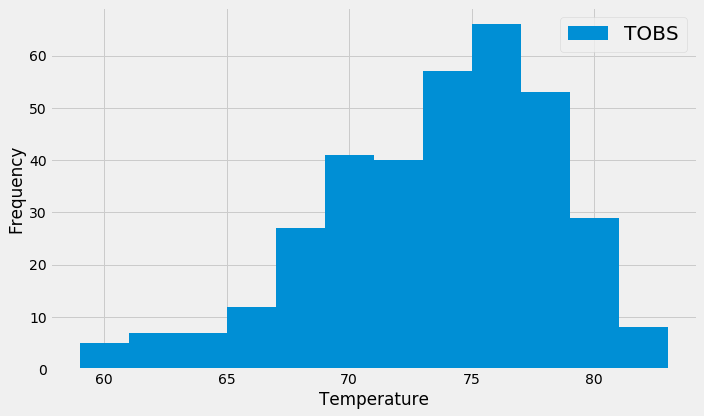

In [108]:
plt.figure(figsize=(10,6))
plt.hist(temp_df["TOBS"], bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend(["TOBS"], fontsize=20)
plt.tight_layout()
plt.savefig("../sqlalchemy-challenge/Images/frequecy.png")


In [60]:
plt.show()

## Bonus Challenge Assignment

In [61]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [120]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
trip_temps = calc_temps('2017-08-13', '2017-08-23')
trip_temps

[(70.0, 78.71111111111111, 85.0)]

In [121]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_temps, columns=["TMIN", "TAVG", "TMAX"])
trip_df

,TMIN,TAVG,TMAX
0,70.0,78.711111,85.0


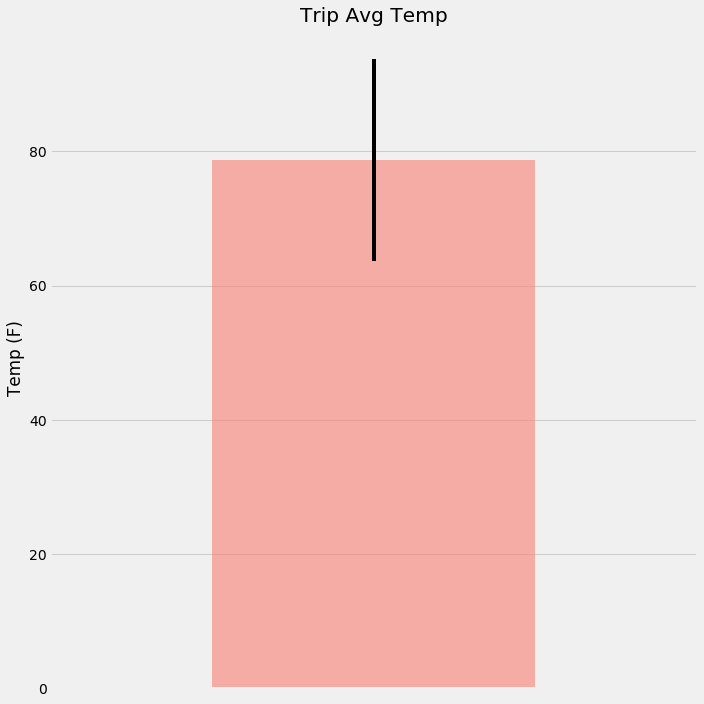

In [123]:
plt.figure(figsize=(10,10))
ax=trip_df["TAVG"].plot.bar(yerr=(trip_df["TMAX"]-trip_df["TMIN"]), color="salmon", alpha=0.6)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
ax.axes.get_xaxis().set_visible(False)
plt.tight_layout()
plt.savefig("../sqlalchemy-challenge/Images/avg_temp.png")
plt.show()

In [87]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start = '2017-08-13'
end = '2017-08-23'
sel = [func.count(Measurement.prcp),Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation]
rain_query=session.query(*sel).filter(Measurement.station==Station.station)
rain_filter = rain_query.group_by(Measurement.station).filter(Measurement.date >= start).filter(Measurement.date <= end)
rain_order = rain_filter.order_by(func.count(Measurement.prcp).desc()).all()

rain_order_df = pd.DataFrame(rain_order, columns = ["Inches of Rainfall", "Station", "Name", "Latitude", "Longitude", "Elevation"])
rain_order_df

,Inches of Rainfall,Station,Name,Latitude,Longitude,Elevation
0,9,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,9,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,7,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9


In [88]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [97]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = '2017-08-13'
end = '2017-08-23'

# Use the start and end date to create a range of dates   
# Stip off the year and save a list of %m-%d strings
trip_dates =[]
norms = []
start_date = dt.datetime.strptime(start, '%Y-%m-%d')
end_date = dt.datetime.strptime(end, '%Y-%m-%d')
date_range = end_date-start_date

for i in range(date_range.days +1):
    day = start_date + dt.timedelta(days=i)
    month_day = dt.datetime.strftime(day,'%m-%d')
    trip_dates.append(month_day)

trip_dates    

['08-13',
 '08-14',
 '08-15',
 '08-16',
 '08-17',
 '08-18',
 '08-19',
 '08-20',
 '08-21',
 '08-22',
 '08-23']

In [98]:
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in trip_dates:
    norms.append(daily_normals(date)[0])
norms

[(71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0),
 (69.0, 76.47169811320755, 83.0),
 (69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0)]

In [102]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norms_df = pd.DataFrame(norms,columns=["TMIN","TAVG","TMAX"],index=[trip_dates])
norms_df.index = norms_df.index.get_level_values(0)
norms_df

,TMIN,TAVG,TMAX
08-13,71.0,76.982456,84.0
08-14,71.0,76.777778,82.0
08-15,69.0,76.471698,83.0
08-16,69.0,76.080000,83.0
08-17,69.0,76.125000,83.0
08-18,70.0,76.923077,84.0
08-19,69.0,75.946429,85.0
08-20,68.0,76.452830,82.0
08-21,67.0,76.400000,83.0
08-22,69.0,76.471698,84.0


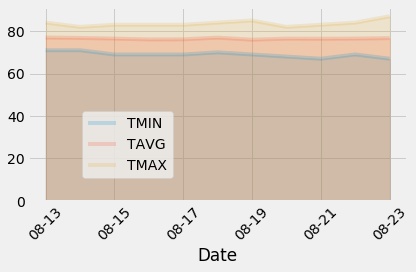

In [116]:
# Plot the daily normals as an area plot with `stacked=False`
tplot = norms_df.plot(kind="area",stacked=False,rot=45,alpha=.2)
plt.xlabel("Date")
plt.legend(["TMIN", "TAVG", "TMAX"])
tplot.get_legend().set_bbox_to_anchor((0.4, 0.5))
plt.tight_layout()
plt.savefig("../sqlalchemy-challenge/Images/daily_normals.png")